![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

# Inteligencia Artificial

# Practica 05

## Aplicaciones de Redes Neuronales y Redes Bayesianas como herramientas de soporte a la toma de decisiones. Despliegue de servicios de Inteligencia Artificial

### Autor: Diego Tapia

## Desarrollo

#### Esta practica se divide en siete partes:

1. Fase de preparación

2. Fase de modelado: Red Neuronal

3. **Fase de modelado: Naive Bayes**

4. Comparacion de modelos

5. Fase de predicción de nuevos samples (Red Neuronal y Naive Bayes)

6. Proyecto en Django Framework

7. Despliegue del proyecto


In [ ]:
# Importacion de librerias

#%pip install scikeras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config

print("Módulos y clases importados")

Módulos y clases importados


## Fase 3. Modelado Naive Bayes

### Importacion de recursos

Se carga el pipeline de la fase 1

In [ ]:
def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline


In [ ]:
pipe = cargarPipeline('pipeline_bank_data')
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['education']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['job', 'marital',
                                                   'contact'])])),
                ('prepstandard',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transcaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24])]))])

Se carga el dataset preparado de la fase 1

In [ ]:
dataframe = pd.read_csv("dataset_preparado.csv", sep=";", header=0)
dataframe.head()

,age,job,marital,education,balance,housing,loan,contact,duration,campaign,result
0,58,management,married,tertiary,2143,1,0,unknown,261,1,0
1,44,technician,single,secondary,29,1,0,unknown,151,1,0
2,33,entrepreneur,married,secondary,2,1,1,unknown,76,1,0
3,47,blue-collar,married,unknown,1506,1,0,unknown,92,1,0
4,33,unknown,single,unknown,1,0,0,unknown,198,1,0


Separacion de la variable independiete (objetivo) y las variables dependientes

In [ ]:
Y = dataframe['result']
dataframe.drop('result', axis=1, inplace=True)
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: result, dtype: int64

In [ ]:
X=copy.deepcopy(dataframe)
X.head()

,age,job,marital,education,balance,housing,loan,contact,duration,campaign
0,58,management,married,tertiary,2143,1,0,unknown,261,1
1,44,technician,single,secondary,29,1,0,unknown,151,1
2,33,entrepreneur,married,secondary,2,1,1,unknown,76,1
3,47,blue-collar,married,unknown,1506,1,0,unknown,92,1
4,33,unknown,single,unknown,1,0,0,unknown,198,1


### Modelado Nayve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB

model_NB = GaussianNB()
#model_NB = MultinomialNB() no se usa, ya que no admite valores negativos
#model_NB = BernoulliNB()
#model_NB = ComplementNB() no se usa, ya que no admite valores negativos
print("modelo naive bayes creado")

# Se agrega al pipeline
pipe.steps.append(['modelNB', model_NB])
#pipe.steps.pop()
print("Cantidad de pasos: ", len(pipe.steps))





modelo naive bayes creado
Cantidad de pasos:  3


In [ ]:
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['education']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['job', 'marital',
                                                   'contact'])])),
                ('prepstandard',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transcaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24])])),
                ['modelNB', GaussianNB()]])

### Entrenamiento modelo naive bayes

In [ ]:
# Función para transformar la predicción
def transformarPrediccion(lista):
    for i in range(len(lista)):
        desempenio=lista[i]
        #print(desempenio)
        if (desempenio < 0.5):
            desempenio = 0
        elif (desempenio >= 0.5):
            desempenio = 1
        lista[i]=desempenio
    return lista

Al igual que el entrenamiento de la red neuronal, se utiliza la técnica de validación cruzada o K-Folding con este modelo.

In [ ]:

from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score

# K-fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados_acumulados = []
for train_index, val_index in kfold.split(X,Y):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

  # Entrenamiento de la red neuronal
  pipe.fit(X_train, y_train)

  # predicion con el conjunto de validacion
  y_pred = pipe.predict(X_val)

  # Evaluacion de la precisión en el conjunto de validacion
  acc = accuracy_score(y_val, transformarPrediccion(y_pred))
  resultados_acumulados.append(acc)

print("Resultados validacion cruzada: \n", resultados_acumulados)
print("Precision media: ", np.mean(resultados_acumulados))
print('Modelo Naive Bayes entrenado')

Resultados validacion cruzada: 
 [0.8427512993475617, 0.8443928334439283, 0.8398584383985844, 0.8377571333775713, 0.8356558283565583]
Precision media:  0.8400831065848408
Modelo Naive Bayes entrenado


### Predicción con el conjuntio de Testing: modelo naive bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
y_pred = pipe.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_NN_con_transformacion=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_NN_con_transformacion.head(10)

,real,predicción clase
3776,0,0
9928,0,0
33409,0,1
31885,0,0
15738,0,0
30813,0,0
35463,0,0
31382,0,0
16904,0,0
11930,0,0


### Evaluación de la calidad del modelo  Naive Bayes

Mean Absolute Error (MAE): 0.1634
Mean Squared Error (MSE): 0.1634
Root Mean Squared Error (RMSE): 0.4043
Accuracy: 0.8365586641601238
Precision:  0.3603
Recall:  0.4574
F1: 0.4031
Matriz de confusión:
Verdaderos negativos:  7066  Falsos positivos:  886  Falsos negativos:  592  Verdaderos positivos:  499


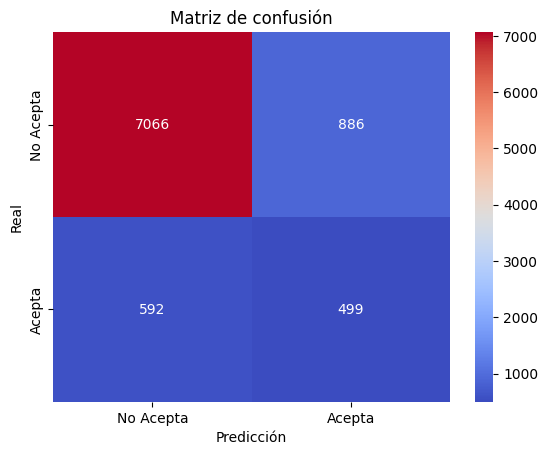

In [ ]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Acepta', 'Acepta']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

### Tabla resultados distintos clasificadores Naive Bayes


Tabla 1. Medidas de evaluación de clasificadores de Naive Bayes

|Modelo| Accuracy| Presicion| Recall| F1-Score|
|-----------|---------|----------|---------|-------|
| Gaussian| 0.8365|0.3603|0.4574|0.4031|
|Berboulli|0.8702| 0.4361|0.2566| 0.3231|



Debido a que el clasificador Gaussian tiene un mejor valor de Recall que el de Bernoulli, se decide utilizar el modelo de Naive Bayes con clasificador **Gaussian**

### Exportacion Modelo Naive Bayes

Se exporta el modelo con el clasificador Gaussian

In [ ]:
import pickle
def guardarNaiveBayes(modelo, nombreArchivo):
  # se guarda en formato .pickle
  with open('model_NB_bank_data.pickle', 'wb') as file:
    pickle.dump(modelo, file)

guardarNaiveBayes(model_NB, 'model_NB_bank_data')
print("Modelo Naive Bayes Guardado")

Modelo Naive Bayes Guardado
